<a href="https://colab.research.google.com/github/201ssc/python_test1/blob/main/5_2_%EA%B7%B8%EB%A6%AC%EB%93%9C_%EC%84%9C%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=3)
sns.set(rc = {'figure.figsize':(12,8)})

from pandas.core.common import random_state

In [3]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys
if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz
    !wget -q -O data.tar.gz https://bit.ly/data-tar-gz
    !tar -xzf data.tar.gz
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    fm._rebuild()

In [4]:
import sklearn
from preamble import *
import matplotlib

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 5.2 그리드 서치

아에 모델의 일반성능을 측정하였고 이젠 매개 변수를 튜닝해 일반화 성능을 개선하겠다. 매개변수 조정하기 전 그 개개변수의 의미를 이해하는 것은 중요하다 모델에서 중요 매개변수의 값을 찾는 건 어려운 작업이지만, 모든 모델과 데이터 셋에서 해야 하는 필수적인 작업이기 때문이다. scikit-learn 에서는 이를 위해 grid search 로 관심있는 매개변수들을 대상으로 가능한 모든 조합을 시도해 서치를 가능하도록 하고 있다.

svc 커널에선 커널 폭 gamma 와 규제 매개변수 C를 가지고 있다. 이제 걸정 값을 다르게 해 어떤 차이가 있는 지 확인해보자. 6개씩 있어 총 조합은 36가지이다.

### 5.2.1 간단한 그리드 서치
두 매개변수 조합에 대해 분류기를 학습시키고 평가하는 간단한 그리드 서치를 for 문을 사용해 만들자

In [5]:
from sklearn.svm import SVC
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("훈련 세트의 크기: {} 테스트 세트의 크기: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # testset svc 평가
    score = svm.score(X_test, y_test)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C":C, "gamma":gamma}

print("best score : {:.2f}".format(best_score))
print("best parameters :", best_parameters)

훈련 세트의 크기: 112 테스트 세트의 크기: 38
best score : 0.97
best parameters : {'C': 100, 'gamma': 0.001}


## 5.2.2  매개변수 과대적합과 검증 셋

이 데이터셋 모델 정확도가 97%라고 했으나 다음과 같은 생각을 해볼 수 있다
- 이 정확도는 새로운 데이터까지 이어지지 않을 수 있다
- 모델을 만들때 사용하지 않는 데이터 셋이 필요하다.

과정은 다음과 같다. 데이터를 세개의 셋으로 만든다
1. 훈련 셋은 모델을 만든다
2. 검증 셋은 모델 매개변수를 선택한다
3. 선택된 매개변수의 성능을 평가한다.

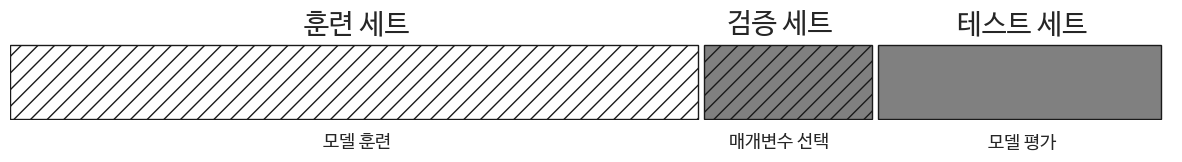

In [6]:
mglearn.plots.plot_threefold_split()

In [7]:
from sklearn.svm import SVC
iris = load_iris()

# 데이터를 훈련+검증 셋 그리고 테스트 셋으로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 훈련+검증 셋을 훈련 셋와 검증 셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {} 검증 세트의 크기: {} 테스트 세트의 크기: {}".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # testset svc 평가
    score = svm.score(X_valid, y_valid)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C":C, "gamma":gamma}

# 훈련셋 검증 셋 합쳐 하나의 모델을 다시 만듬
# 테스트 셋을 사용해 평가합니다.
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("best score in valid set : {:.2f}".format(best_score))
print("best parameters :", best_parameters)
print("best score in test set: {:.2f}".format(test_score))

훈련 세트의 크기: 84 검증 세트의 크기: 28 테스트 세트의 크기: 38
best score in valid set : 0.96
best parameters : {'C': 10, 'gamma': 0.001}
best score in test set: 0.92


### 5.2.3 교차 검증을 사용한 그리드 서치


In [8]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    # 교차 검증을 적용
    scores = cross_val_score(svm, X_trainval, y_trainval, cv= 5)
    # 교차 검증 정확도ㅢ 평균을 구한다.
    score = np.mean(scores)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {'C': C, 'gamma': gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든다.
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)


SVC(C=10, gamma=0.1)

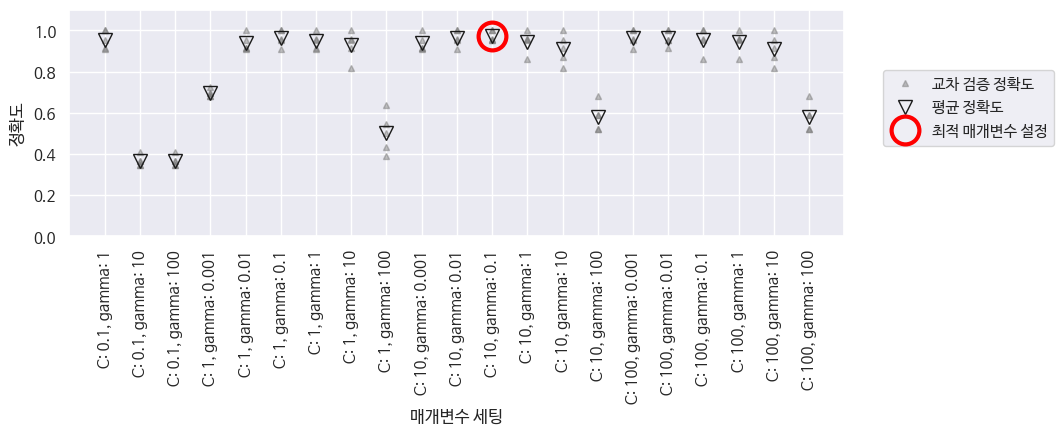

In [9]:
mglearn.plots.plot_cross_val_selection()

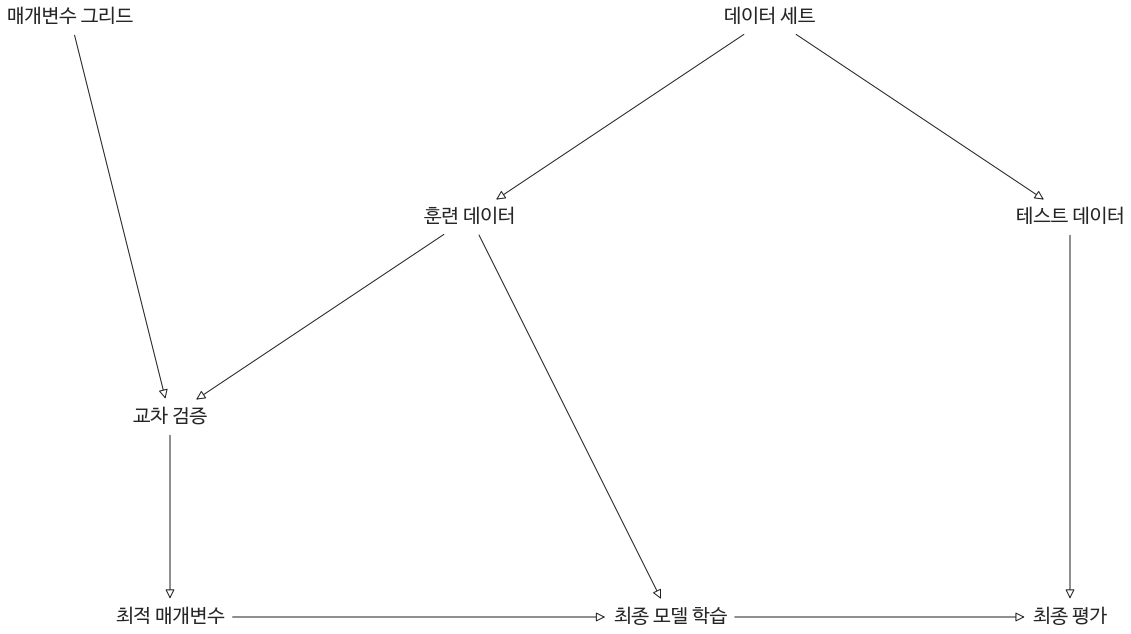

In [10]:
mglearn.plots.plot_grid_search_overview()

교차 검증을 사용한 그리드 서치를 매개변수 조정 방법으로 널리 사용하기 때문에 scikit learn은 추정기 형태로 구현된 GridSearchCV 를 제공하고 있따. 이를 사용하려면 먼저 딕셔너리 형태로 검색 대상 매개변수를 지정해야 한다.GridSearchCV는 필요한 모든 모델을 학습시킨다. 

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print('매개변수 그리드: \n', param_grid)

매개변수 그리드: 
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [12]:
from seaborn.axisgrid import Grid
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [16]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [17]:
print("테스트 셋 점수 : {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 셋 점수 : 0.97


In [18]:
print('최적의 매개변수:', grid_search.best_params_)
print('최고 교차 검증 점수: {:.2f}'.format(grid_search.best_score_))

최적의 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97


In [20]:
print('최고 성능 모델:\n', grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=10, gamma=0.1)
